# Corrélations non linéaires

Les corrélations indiquent si deux variables sont linéairement équivalentes. Comment étendre cette notion à des variables liées mais pas de façon linéaire.

In [2]:
%matplotlib inline

## Un exemple

In [3]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
Y = iris.target
import pandas

df = pandas.DataFrame(X)
df.columns = ["X1", "X2", "X3", "X4"]
df.head()

,X1,X2,X3,X4
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


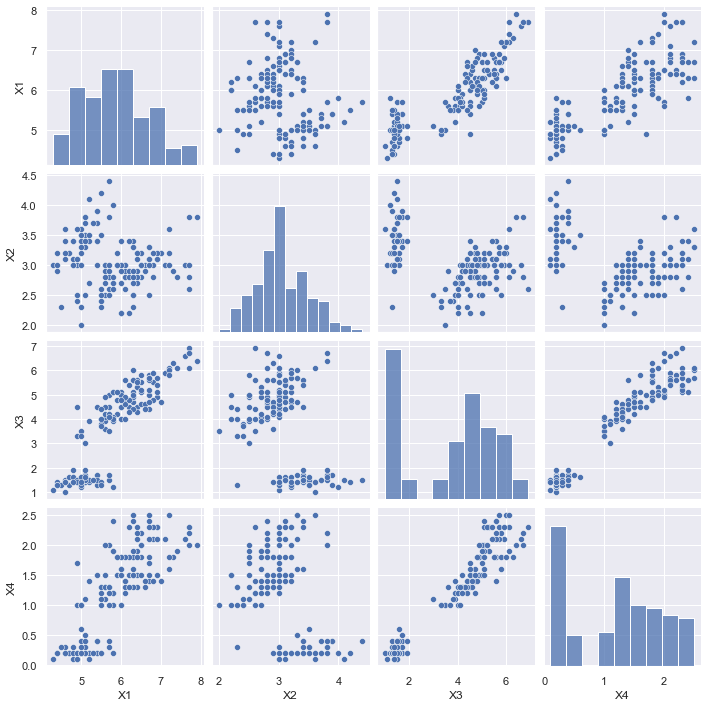

In [4]:
import seaborn as sns

sns.set()
sns.pairplot(df);

Et les corrélations :

In [5]:
df.corr()

,X1,X2,X3,X4
X1,1.000000,-0.117570,0.871754,0.817941
X2,-0.117570,1.000000,-0.428440,-0.366126
X3,0.871754,-0.428440,1.000000,0.962865
X4,0.817941,-0.366126,0.962865,1.000000


## Un peu de théorie

Le coefficient de [corrélation](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)) de Pearson est calculé comme suit :

$$cor(X_i, X_j) = \frac{cov(X_i, Y_i)}{\sigma(X_i)\sigma(X_j)}$$

Lorsque les variables sont centrées $\mathbb{E}X_i=\mathbb{E}X_j=0$, cette formule devient :

$$cor(X_i, X_j) = \frac{\mathbb{E}(X_i X_j)}{\sqrt{\mathbb{E}X_i^2 \mathbb{E}X_j^2}}$$

Lorsque les variables sont réduites $\mathbb{E}X_i^2=\mathbb{E}X_j^2=1$, cette formule devient $cor(X_i, X_j) = \mathbb{E}(X_i X_j)$. Admettons maintenant que l'on cherche à trouver le coefficient $\alpha_{ij}$ qui minimise la variance du bruit $\epsilon_{ij}$ :

$$X_j = \alpha_{ij}X_i + \epsilon_{ij}$$

Le coefficient $\alpha_{ij}$ est le résultat d'une régression linéaire qui minimise $\mathbb{E}(X_j - \alpha_{ij}X_i)^2$. Si les variables $X_i$, $X_j$ sont centrées et réduites : $\alpha_{ij}^* = \mathbb{E}(X_i X_j) = cor(X_i, X_j)$. On étend cette définition dans le cas d'une fonction paramétrable $f$ : $f(\omega, X) \rightarrow \mathbb{R}$ et d'une régression non linéaire. On suppose que les paramètres $\omega^*$ minimisent la quantité $\min_\omega (X_j  - f(\omega, X_i))^2$. On écrit alors $X_j = \alpha_{ij} \frac{f(\omega^*, X_i)}{\alpha_{ij}} + \epsilon_{ij}$ et on choisit $\alpha_{ij}$ de telle sorte que $\mathbb{E}\left(\frac{f(\omega^*, X_i)^2}{\alpha_{ij}^2}\right) = 1$. On définit la corrélation non linéaire au sens de $f$ : 

$$cor^f(X_i, X_j) = \sqrt{ \mathbb{E} (f(\omega, X_i)^2 )}$$

On vérifie que ce coefficient est compris entre [0, 1]. Il est positif de manière évidente. Il est également inférieur à 1, si cela n'était pas le cas, nous pourrions construire une fonction $f(\omega^*, X)+c$ qui est une meilleur solution pour le programme de minimisation. Ce nombre ressemble à une corrélation à ceci près qu'elle ne peut être négative.

## Vérifications

Tout d'abord le cas linéaire :

In [6]:
from sklearn.preprocessing import scale
import numpy


def correlation_etendue(df, model, **params):
    cor = df.corr()
    df = scale(df)
    for i in range(cor.shape[0]):
        xi = df[:, i : i + 1]
        for j in range(cor.shape[1]):
            mod = model(**params)
            xj = df[:, j]
            mod.fit(xi, xj)
            v = mod.predict(xi)
            c = numpy.std(v)
            cor.iloc[i, j] = c
    return cor


from sklearn.linear_model import LinearRegression

cor = correlation_etendue(df, LinearRegression, fit_intercept=False)
cor

,X1,X2,X3,X4
X1,1.000000,0.117570,0.871754,0.817941
X2,0.117570,1.000000,0.428440,0.366126
X3,0.871754,0.428440,1.000000,0.962865
X4,0.817941,0.366126,0.962865,1.000000


On affiche à nouveau les corrélations qui sont identiques au signe près.

In [7]:
df.corr()

,X1,X2,X3,X4
X1,1.000000,-0.117570,0.871754,0.817941
X2,-0.117570,1.000000,-0.428440,-0.366126
X3,0.871754,-0.428440,1.000000,0.962865
X4,0.817941,-0.366126,0.962865,1.000000


Et le cas non linéaire :

In [8]:
from sklearn.tree import DecisionTreeRegressor

cor = correlation_etendue(df, DecisionTreeRegressor)
cor

,X1,X2,X3,X4
X1,1.000000,0.544441,0.915847,0.879583
X2,0.418274,1.000000,0.591839,0.539524
X3,0.937056,0.789727,1.000000,0.978332
X4,0.846161,0.761652,0.980005,1.000000


In [9]:
from sklearn.ensemble import RandomForestRegressor

cor = correlation_etendue(df, RandomForestRegressor, n_estimators=10)
cor

,X1,X2,X3,X4
X1,0.998300,0.557325,0.924134,0.871019
X2,0.413502,0.992939,0.593398,0.544801
X3,0.922292,0.786128,0.999064,0.975211
X4,0.846106,0.756621,0.981181,0.999269


## Overfitting

Ces chiffres sont beaucoup trop optimistes. Les modèles de machine learning peuvent tout à fait faire de l'overfitting. Il faut améliorer la fonction en divisant en apprentissage et test plusieurs fois. Il faut également tenir compte de l'erreur de prédiction. On rappelle que : 

$$X_j = \alpha_{ij} \frac{f(\omega^*, X_i)}{\alpha_{ij}} + \epsilon_{ij} = cor^f(X_i, X_j) \frac{f(\omega^*, X_i)}{\sqrt{ \mathbb{E} (f(\omega, X_i)^2 )}} + \epsilon_{ij}$$

Or $\mathbb{E}(X_j^2)=1$ et on suppose que les bruits ne sont pas corrélées linéairement aux $f(\omega^*, X_i)$. On en déduit que $cor^f(X_i, X_j) = \sqrt{ 1 - \mathbb{E}\epsilon_{ij}^2}$.

In [10]:
from sklearn.model_selection import train_test_split


def correlation_cross_val(df, model, draws=5, **params):
    cor = df.corr()
    df = scale(df)
    for i in range(cor.shape[0]):
        xi = df[:, i : i + 1]
        for j in range(cor.shape[1]):
            xj = df[:, j]
            mem = []
            for k in range(draws):
                xi_train, xi_test, xj_train, xj_test = train_test_split(
                    xi, xj, test_size=0.5
                )
                mod = model(**params)
                mod.fit(xi_train, xj_train)
                v = mod.predict(xi_test)
                c = 1 - numpy.var(v - xj_test)
                mem.append(max(c, 0) ** 0.5)
            cor.iloc[i, j] = sum(mem) / len(mem)
    return cor


cor = correlation_cross_val(df, LinearRegression, fit_intercept=False, draws=20)
cor

,X1,X2,X3,X4
X1,1.000000,0.067090,0.878802,0.817301
X2,0.156402,1.000000,0.355925,0.347753
X3,0.878156,0.421116,1.000000,0.963497
X4,0.808738,0.378046,0.961512,1.000000


In [11]:
cor = correlation_cross_val(df, DecisionTreeRegressor)
cor

,X1,X2,X3,X4
X1,0.999140,0.000000,0.840661,0.792892
X2,0.000000,0.995369,0.268502,0.202563
X3,0.864010,0.492400,0.999257,0.955225
X4,0.715695,0.539786,0.968522,0.999316


In [12]:
cor = correlation_cross_val(df, RandomForestRegressor, n_estimators=10)
cor

,X1,X2,X3,X4
X1,0.998919,0.048290,0.872549,0.794800
X2,0.064102,0.996025,0.209190,0.201094
X3,0.875400,0.481419,0.998478,0.958236
X4,0.733457,0.656183,0.967662,0.999501


Les résultats sont assez fluctuants lorsque les données sont mal corrélées. On remarque également que la matrice n'est plus nécessairement symmétrique.

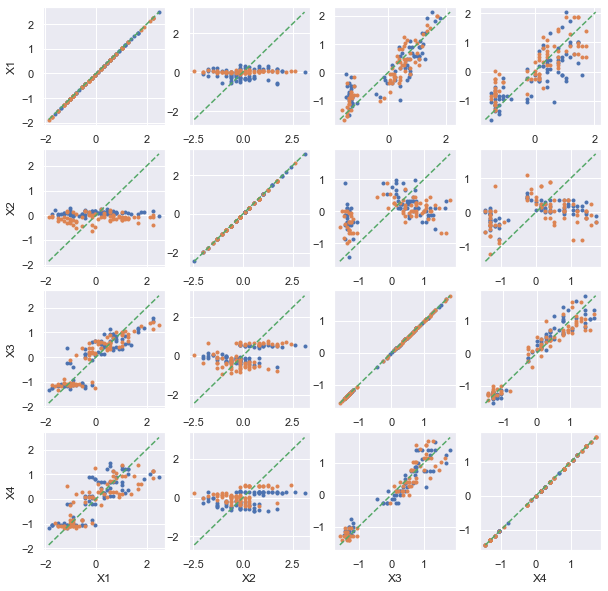

In [13]:
import matplotlib.pyplot as plt


def pairplot_cross_val(data, model=None, ax=None, **params):
    if ax is None:
        fig, ax = plt.subplots(
            data.shape[1], data.shape[1], figsize=params.get("figsize", (10, 10))
        )
    if "figsize" in params:
        del params["figsize"]
    if model is None:
        from sklearn.linear_model import LinearRegression

        model = LinearRegression

    df = scale(data)
    cor = numpy.corrcoef(df.T)
    for i in range(cor.shape[0]):
        xi = df[:, i : i + 1]
        for j in range(cor.shape[1]):
            xj = df[:, j]
            xi_train, xi_test, xj_train, xj_test = train_test_split(
                xi, xj, test_size=0.5
            )
            mod = model(**params)
            mod.fit(xi_train, xj_train)
            v = mod.predict(xi_test)
            mod = model(**params)
            mod.fit(xi_test, xj_test)
            v2 = mod.predict(xi_train)
            ax[i, j].plot(xj_test, v, ".")
            ax[i, j].plot(xj_train, v2, ".")
            if j == 0:
                ax[i, j].set_ylabel(data.columns[i])
            if i == data.shape[1] - 1:
                ax[i, j].set_xlabel(data.columns[j])
            mi = min(min(xj_test), min(v), min(xj_train), min(v2))
            ma = max(max(xj_test), max(v), max(xj_train), max(v2))
            ax[i, j].plot([mi, ma], [mi, ma], "--")
    return ax


ax = pairplot_cross_val(df)
ax;

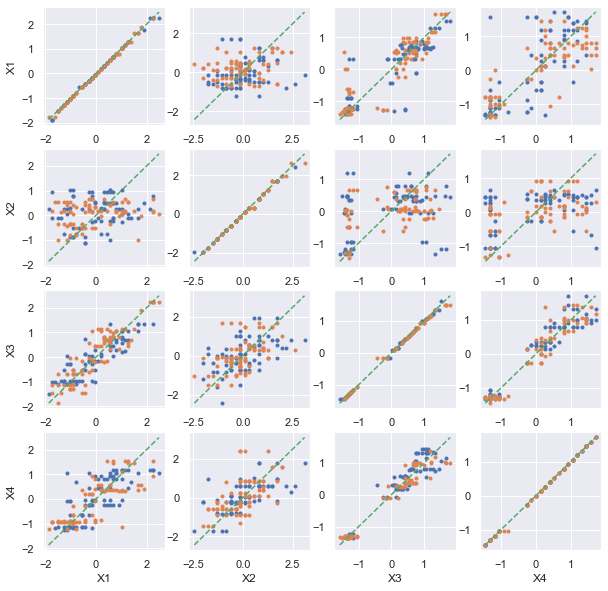

In [14]:
ax = pairplot_cross_val(df, model=DecisionTreeRegressor)
ax;

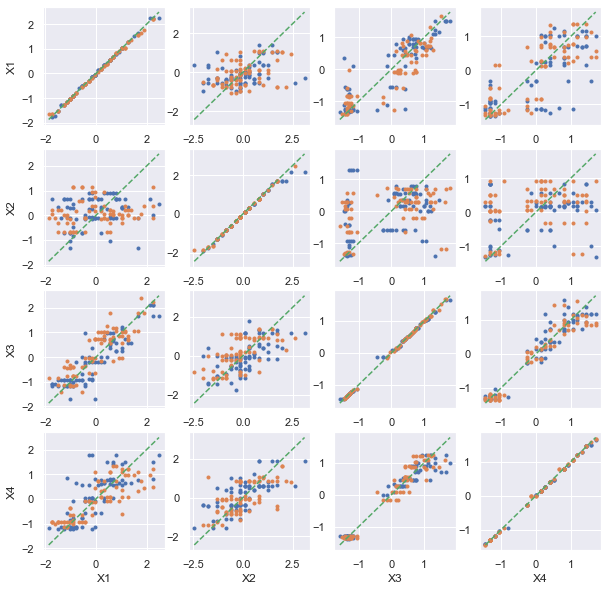

In [15]:
ax = pairplot_cross_val(df, model=RandomForestRegressor, n_estimators=10)
ax;

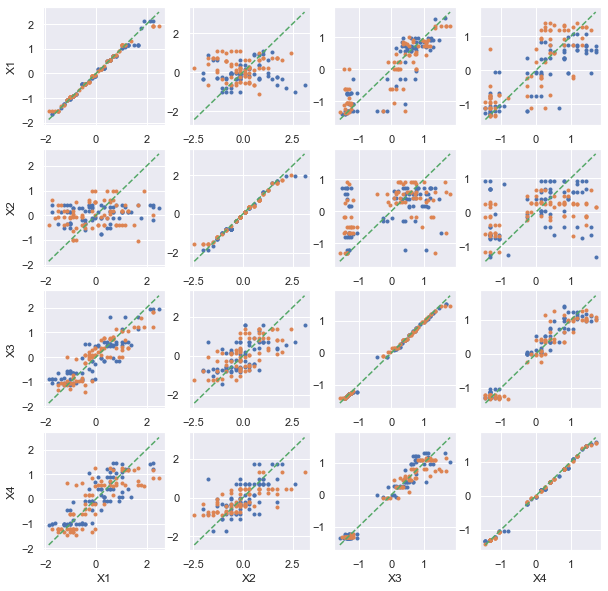

In [16]:
from sklearn.neighbors import KNeighborsRegressor

ax = pairplot_cross_val(df, model=KNeighborsRegressor)
ax;

## Corrélations de variables catégorielles

C'est le problème épineux si on se restreint au linéaire. Cela n'a pas trop de sens d'affecter une valeur à chaque catégorie et la corrélation de deux variables binaires (des modalités) est toujours étrange car il n'y a que deux valeurs possibles.

$$cov(X,Y) = \mathbb{E}\left[(X - \mathbb{E}X)(Y - \mathbb{E}Y)\right] = \mathbb{E}(XY) - \mathbb{E}X\mathbb{E}Y = \mathbb{P}(X=1 \, et \, Y=1) - \mathbb{E}X\mathbb{E}Y$$

Dans le cas de variables binaires générées de modalités de la même variables catégorielles, le premier terme est toujours nul puisque les modalités sont exclusives et la corrélation est toujours négative.

In [17]:
import random

ex = numpy.zeros((100, 2))
for i in range(ex.shape[0]):
    h = random.randint(0, ex.shape[1] - 1)
    ex[i, h] = 1
ex[:5]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [18]:
numpy.corrcoef(ex.T)

array([[ 1., -1.],
       [-1.,  1.]])

In [19]:
import random

ex = numpy.zeros((100, 3))
for i in range(ex.shape[0]):
    h = random.randint(0, ex.shape[1] - 1)
    ex[i, h] = 1
ex[:5]
numpy.corrcoef(ex.T)

array([[ 1.        , -0.45760432, -0.47790696],
       [-0.45760432,  1.        , -0.56235159],
       [-0.47790696, -0.56235159,  1.        ]])

Supposons maintenant que nous avons deux variables catégorielles très proches :

* $X_1$ est une couleur rouge, bleu, gris.
* $X_2$ est une nuance rose, orange, cyan, magenta, blanc noir.

In [20]:
c1 = ["rouge", "bleu", "gris"]
c2 = ["rose", "orange", "cyan", "magenta", "blanc", "noir"]
ind = [random.randint(0, 2) for i in range(100)]
x1 = [c1[i] for i in ind]
x2 = [c2[i * 2 + random.randint(0, 1)] for i in ind]
df = pandas.DataFrame(dict(X1=x1, X2=x2))
df.head()

,X1,X2
0,rouge,rose
1,gris,noir
2,bleu,magenta
3,bleu,magenta
4,bleu,magenta


On peut évidemment transformer en entier.

In [21]:
dummies = pandas.get_dummies(df)
dummies.head()

,X1_bleu,X1_gris,X1_rouge,X2_blanc,X2_cyan,X2_magenta,X2_noir,X2_orange,X2_rose
0,0,0,1,0,0,0,0,0,1
1,0,1,0,0,0,0,1,0,0
2,1,0,0,0,0,1,0,0,0
3,1,0,0,0,0,1,0,0,0
4,1,0,0,0,0,1,0,0,0


In [22]:
dummies.corr()

,X1_bleu,X1_gris,X1_rouge,X2_blanc,X2_cyan,X2_magenta,X2_noir,X2_orange,X2_rose
X1_bleu,1.000000,-0.548514,-0.511019,-0.399795,0.545824,0.683520,-0.295268,-0.309086,-0.348970
X1_gris,-0.548514,1.000000,-0.438420,0.728869,-0.299392,-0.374920,0.538305,-0.265175,-0.299392
X1_rouge,-0.511019,-0.438420,1.000000,-0.319551,-0.278927,-0.349292,-0.236004,0.604842,0.682890
X2_blanc,-0.399795,0.728869,-0.319551,1.000000,-0.218218,-0.273268,-0.184637,-0.193278,-0.218218
X2_cyan,0.545824,-0.299392,-0.278927,-0.218218,1.000000,-0.238528,-0.161165,-0.168707,-0.190476
X2_magenta,0.683520,-0.374920,-0.349292,-0.273268,-0.238528,1.000000,-0.201822,-0.211266,-0.238528
X2_noir,-0.295268,0.538305,-0.236004,-0.184637,-0.161165,-0.201822,1.000000,-0.142745,-0.161165
X2_orange,-0.309086,-0.265175,0.604842,-0.193278,-0.168707,-0.211266,-0.142745,1.000000,-0.168707
X2_rose,-0.348970,-0.299392,0.682890,-0.218218,-0.190476,-0.238528,-0.161165,-0.168707,1.000000


Ca ne dit pas grand-chose.

In [23]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
df["X1e"] = enc.fit_transform(df["X1"])
df["X2e"] = enc.fit_transform(df["X2"])
df.head()

,X1,X2,X1e,X2e
0,rouge,rose,2,5
1,gris,noir,1,3
2,bleu,magenta,0,2
3,bleu,magenta,0,2
4,bleu,magenta,0,2


In [24]:
df.corr()

C:\Users\xavie\AppData\Local\Temp\ipykernel_148816\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,X1e,X2e
X1e,1.000000,0.661507
X2e,0.661507,1.000000


Ca ne veut toujours pas dire grand-chose. Et si on change la première colonne en permutant les lables :

In [25]:
df["X1e"] = df["X1e"].apply(lambda i: (i + 1) % 3)
df.head()

,X1,X2,X1e,X2e
0,rouge,rose,0,5
1,gris,noir,2,3
2,bleu,magenta,1,2
3,bleu,magenta,1,2
4,bleu,magenta,1,2


In [26]:
df.corr()

C:\Users\xavie\AppData\Local\Temp\ipykernel_148816\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,X1e,X2e
X1e,1.000000,-0.767644
X2e,-0.767644,1.000000


La corrélation linéaire sur des variables catégorielles n'a pas de sens. Essayons avec un arbre de décision. C'est le modèle adéquat pour ce type de valeur discrètes :

In [27]:
cor = correlation_cross_val(df[["X1e", "X2e"]], DecisionTreeRegressor)
cor

,X1e,X2e
X1e,1.0,0.829865
X2e,1.0,1.000000


Et si on permute le premier label :

In [28]:
df["X1e"] = df["X1e"].apply(lambda i: (i + 1) % 3)
correlation_cross_val(df[["X1e", "X2e"]], DecisionTreeRegressor)

,X1e,X2e
X1e,1.0,0.829759
X2e,1.0,1.000000


Même résultat qui s'interprète de la sorte :

* La variable *X1e* se déduit de *X2e* (car *cor(X2e, X1e) = 1*).
* La variable *X2e* et fortement lié à *X2e*.

La valeur numérique choisie pour représente la variable catégorielle n'a pas d'impact sur les résultats.

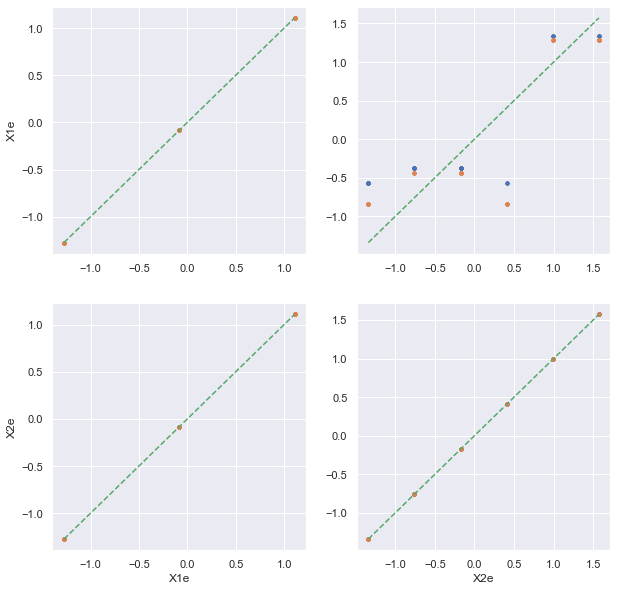

In [29]:
ax = pairplot_cross_val(df[["X1e", "X2e"]], model=DecisionTreeRegressor)
ax;

Et sur un jeu de données plus complet.

In [30]:
from sklearn.datasets import load_diabetes

df = load_diabetes()
df = pandas.DataFrame(df.data, columns=df.feature_names)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [31]:
df.corr()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000


On dessine les 5 premières variables. On voit que la variable CHAS est binaire.

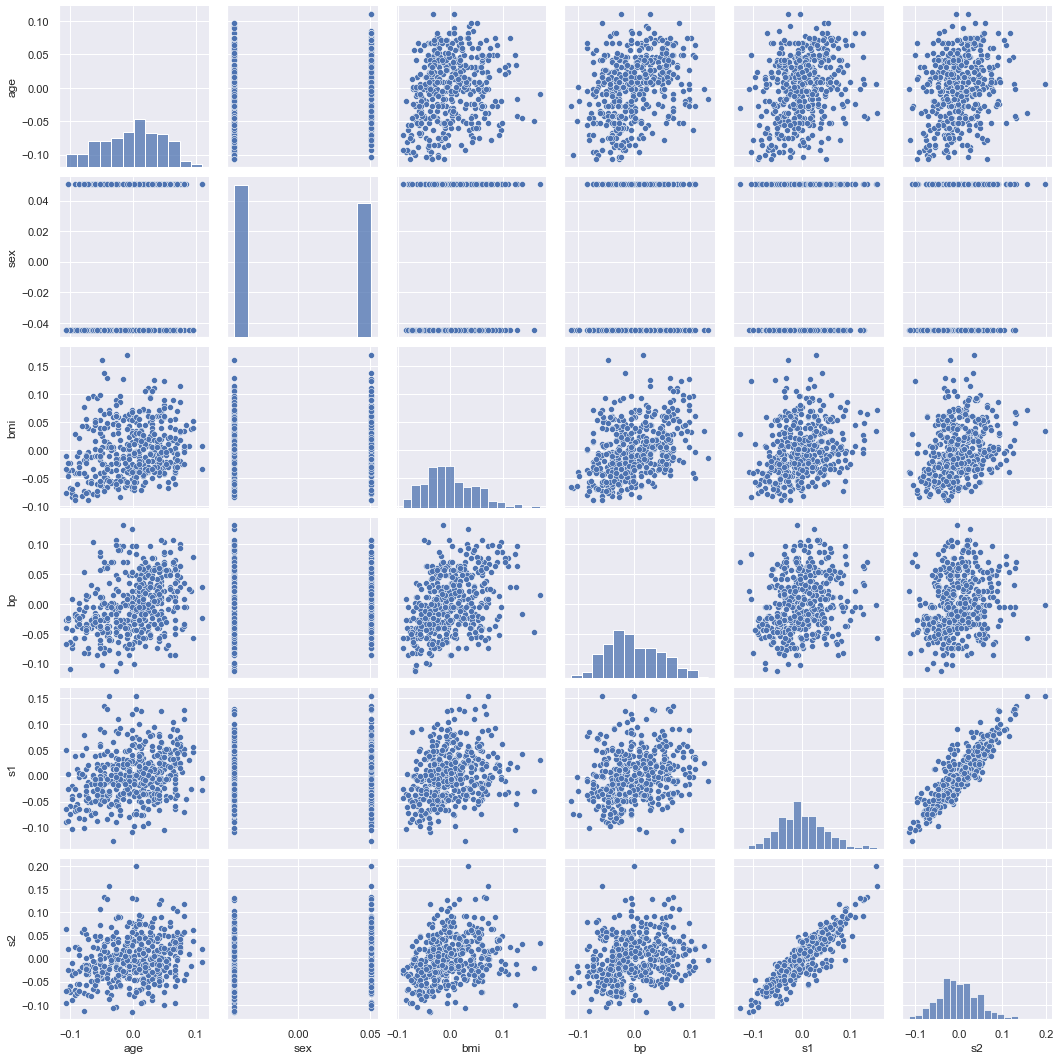

In [32]:
sns.pairplot(df[df.columns[:6]]);

In [33]:
correlation_cross_val(df, DecisionTreeRegressor)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
age,0.999796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sex,0.027919,1.000000,0.157867,0.166623,0.191943,0.237330,0.324815,0.339291,0.067600,0.174746
bmi,0.000000,0.000000,0.998443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bp,0.000000,0.000000,0.067004,0.999742,0.034283,0.000000,0.000000,0.000000,0.093270,0.000000
s1,0.000000,0.000000,0.000000,0.000000,0.999590,0.818878,0.000000,0.000000,0.015104,0.000000
s2,0.000000,0.000000,0.000000,0.000000,0.799865,0.999630,0.000000,0.050950,0.000000,0.000000
s3,0.000000,0.022461,0.000000,0.000000,0.000000,0.000000,0.999374,0.715070,0.059192,0.000000
s4,0.123848,0.045933,0.280093,0.000000,0.425411,0.593638,0.718139,0.999282,0.542289,0.215026
s5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055251,0.999593,0.000000
s6,0.000000,0.000000,0.000000,0.074782,0.026652,0.000000,0.000000,0.000000,0.115111,0.999659


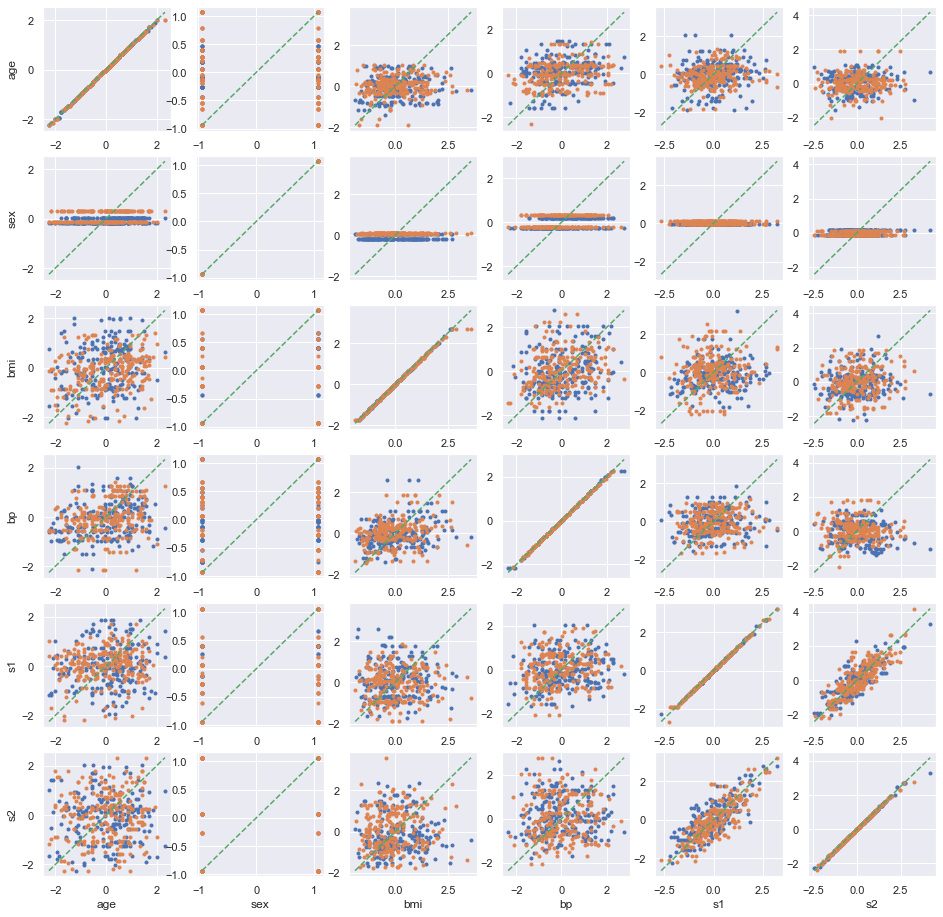

In [34]:
pairplot_cross_val(df[df.columns[:6]], model=DecisionTreeRegressor, figsize=(16, 16));

On regarde en pariculier les variables TAX, RAD, PTRATIO.

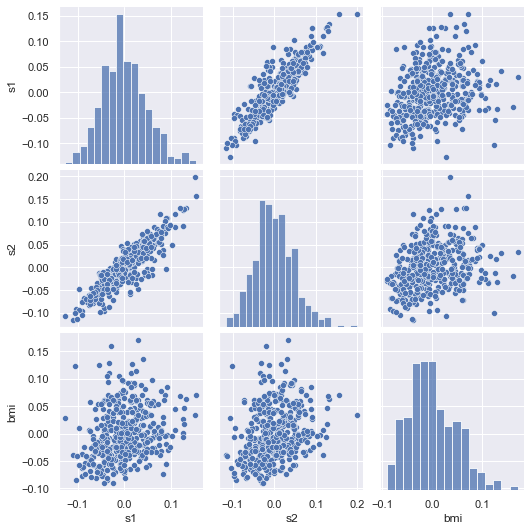

In [35]:
sns.pairplot(df[["s1", "s2", "bmi"]]);

In [36]:
df[["s1", "s2", "bmi"]].corr()

,s1,s2,bmi
s1,1.000000,0.896663,0.249777
s2,0.896663,1.000000,0.261170
bmi,0.249777,0.261170,1.000000


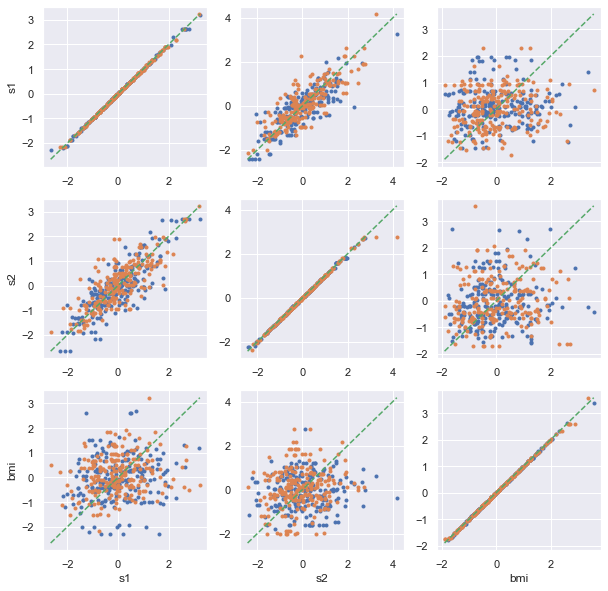

In [37]:
pairplot_cross_val(df[["s1", "s2", "bmi"]], model=DecisionTreeRegressor);

In [38]:
correlation_cross_val(df[["s1", "s2", "bmi"]], DecisionTreeRegressor)

,s1,s2,bmi
s1,0.999247,0.806962,0.000000
s2,0.788846,0.997368,0.000000
bmi,0.000000,0.000000,0.999158


Les variables sont toutes trois liées de façon non linéaire.

## Maximal information coefficient

Cette approche est plutôt pragmatique mais peut se révéler coûteuse en terme de calculs. Elle permet aussi de comprendre qu'un coefficient de corrélation dépend des hypothèses qu'on choisi pour les données. On peut toujours construire un coefficient de corrélation qui soit égal à 1 mais il correspond à toujours à un phénomène qu'on souhaite étudier. La corrélation linéaire recherche des relations linéaires. On peut chercher une relation polynomiale. Les arbres de décision recherche une corrélation construite à partir de fonction en escalier. Plus la relation a de degré de liberté, plus le coefficient a de chance de tendre vers 1, moins il a de chance d'être aussi élevé sur de nouvelles données.

Cela permet néanmoins de mieux comprendre les avantages et les inconvénients de métriques du type [MIC](https://en.wikipedia.org/wiki/Maximal_information_coefficient) ou *Maximal information coefficient*. Plus de détails sont disponibles dans cet article : [Equitability, mutual information, and the maximal information coefficient](https://arxiv.org/abs/1301.7745v1). Le module [minepy](http://minepy.readthedocs.io/en/latest/python.html) implémente cette métrique ainsi que d'autres qui poursuivent le même objectif. L'information mutuelle est définie comme ceci pour deux variables discrètes :

$$MI(X,Y) = \sum_{x\in\mathcal{X}}\sum_{y\in\mathcal{Y}}p(x,y)\ln_2\frac{p(x,y)}{p(x)p(y)}$$

La fonction $p(x,y)$ définit la distribution conjointe des deux variables, $p(x)$, $p(y)$ les deux probabilités marginales. Il existe une extension pour les variables continues :

$$MIC(X,Y) = \int_{x\in\mathcal{X}}\in_{y\in\mathcal{Y}}p(x,y)\ln_2\frac{p(x,y)}{p(x)p(y)}dxdy$$

Une façon de calculer une approximation du coefficient $MIC(x,y)$ est de discrétiser les deux variables $X$ et $Y$ ce qu'on fait en appliquant un algorithme similaire à celui utilisé pour construire un arbre de décision à ceci près que qu'il n'y a qu'une seule variable et que la variable à prédire est elle-même.

L'information mutuelle est inspiré de la distance de [Kullback-Leiber](https://fr.wikipedia.org/wiki/Divergence_de_Kullback-Leibler) qui est une distance entre deux probabilités qui sont ici la disribution du couple $(X,Y)$ et la distribution que ce couple aurait si les deux variables étaient indépendantes, c'est à dire le produit de leur distribution.

In [39]:
%matplotlib inline

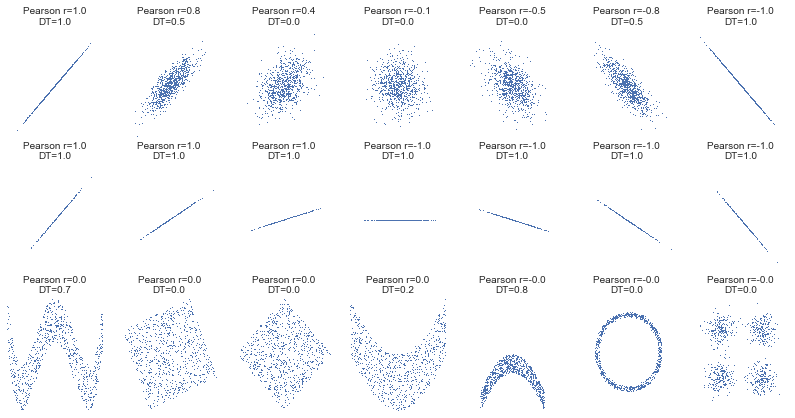

In [40]:
import numpy as np


rs = np.random.RandomState(seed=0)


def mysubplot(x, y, numRows, numCols, plotNum, xlim=(-4, 4), ylim=(-4, 4)):
    r = np.around(np.corrcoef(x, y)[0, 1], 1)

    # début ajout
    df = pandas.DataFrame(dict(x=x, y=y))
    cor = correlation_cross_val(df, DecisionTreeRegressor)
    dt = max(cor.iloc[1, 0], cor.iloc[0, 1])

    ax = plt.subplot(numRows, numCols, plotNum, xlim=xlim, ylim=ylim)
    ax.set_title("Pearson r=%.1f\nDT=%.1f" % (r, dt), fontsize=10)
    ax.set_frame_on(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.plot(x, y, ",")
    ax.set_xticks([])
    ax.set_yticks([])
    return ax


def rotation(xy, t):
    return np.dot(xy, [[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])


def mvnormal(n=1000):
    cors = [1.0, 0.8, 0.4, 0.0, -0.4, -0.8, -1.0]
    for i, cor in enumerate(cors):
        cov = [[1, cor], [cor, 1]]
        xy = rs.multivariate_normal([0, 0], cov, n)
        mysubplot(xy[:, 0], xy[:, 1], 3, 7, i + 1)


def rotnormal(n=1000):
    ts = [
        0,
        np.pi / 12,
        np.pi / 6,
        np.pi / 4,
        np.pi / 2 - np.pi / 6,
        np.pi / 2 - np.pi / 12,
        np.pi / 2,
    ]
    cov = [[1, 1], [1, 1]]
    xy = rs.multivariate_normal([0, 0], cov, n)
    for i, t in enumerate(ts):
        xy_r = rotation(xy, t)
        mysubplot(xy_r[:, 0], xy_r[:, 1], 3, 7, i + 8)


def others(n=1000):
    x = rs.uniform(-1, 1, n)
    y = 4 * (x**2 - 0.5) ** 2 + rs.uniform(-1, 1, n) / 3
    mysubplot(x, y, 3, 7, 15, (-1, 1), (-1 / 3, 1 + 1 / 3))

    y = rs.uniform(-1, 1, n)
    xy = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
    xy = rotation(xy, -np.pi / 8)
    lim = np.sqrt(2 + np.sqrt(2)) / np.sqrt(2)
    mysubplot(xy[:, 0], xy[:, 1], 3, 7, 16, (-lim, lim), (-lim, lim))

    xy = rotation(xy, -np.pi / 8)
    lim = np.sqrt(2)
    mysubplot(xy[:, 0], xy[:, 1], 3, 7, 17, (-lim, lim), (-lim, lim))

    y = 2 * x**2 + rs.uniform(-1, 1, n)
    mysubplot(x, y, 3, 7, 18, (-1, 1), (-1, 3))

    y = (x**2 + rs.uniform(0, 0.5, n)) * np.array([-1, 1])[rs.randint(0, 1, size=n)]
    mysubplot(x, y, 3, 7, 19, (-1.5, 1.5), (-1.5, 1.5))

    y = np.cos(x * np.pi) + rs.uniform(0, 1 / 8, n)
    x = np.sin(x * np.pi) + rs.uniform(0, 1 / 8, n)
    mysubplot(x, y, 3, 7, 20, (-1.5, 1.5), (-1.5, 1.5))

    xy1 = np.random.multivariate_normal([3, 3], [[1, 0], [0, 1]], int(n / 4))
    xy2 = np.random.multivariate_normal([-3, 3], [[1, 0], [0, 1]], int(n / 4))
    xy3 = np.random.multivariate_normal([-3, -3], [[1, 0], [0, 1]], int(n / 4))
    xy4 = np.random.multivariate_normal([3, -3], [[1, 0], [0, 1]], int(n / 4))
    xy = np.concatenate((xy1, xy2, xy3, xy4), axis=0)
    mysubplot(xy[:, 0], xy[:, 1], 3, 7, 21, (-7, 7), (-7, 7))


plt.figure(figsize=(14, 7))
mvnormal(n=800)
rotnormal(n=200)
others(n=800)
# plt.tight_layout()
# plt.show()